In [1]:
import pandas as pd
warm = "warm/"
cold = "cold/"
warm_performance_json = warm + "performances.json"
cold_performance_json = cold + "performances.json"
commands_json = warm + "commands.json"
merlin_responses_json = warm + "query_responses.json"
logs_json = warm + "logs.json"
metadata_json = warm + "metadata.json"


## The merlin cache

Let's have a look whether the cache seems to have been inited correctly during the warm run.

_Explanation_: we've run each `merlin` query on each sample 10 times with the idea to analyze variance. When using the merlin frontend Server (cli-option `warm`), `merl-an` should initialize the `merlin` cache on each file before running the queries.

In [2]:
warm_performance = pd.read_json(warm_performance_json, lines = True)
cold_performance = pd.read_json(cold_performance_json, lines = True)
cold_performance_truncated = cold_performance[["sample_id", "timings", "max_timing"]]
cold_performance_truncated = cold_performance_truncated.rename(columns={"timings" : "cold_timings", "max_timing" : "cold_max_timing"})
performance = pd.merge(warm_performance, cold_performance_truncated, on = "sample_id")
performance = performance.sort_values("max_timing", ascending = False)[["sample_id", "timings", "max_timing", "cold_timings", "cold_max_timing", "query_type", "file"]]

### Observation

On one hand, there're quite a few samples with the following pattern: on `warm`, the first of the 10 queries takes way longer than the other 9. However, the the same queries in `cold` mode take even considerably longer.

This seems to be the case particularly often in the samples that have taken the longest (on `warm).

In [3]:
n = 5
# TODO (note for myself): turns out that it's a horrible idea to store a list inside a pandas series.
# If I want to keep on using pandas, I need to change the layout of the data files.
init_cache_suspicous = performance.copy()
init_cache_suspicous["timings"] = init_cache_suspicous["timings"].apply(lambda ts: ts if ts[0] == max(ts) else None)
init_cache_suspicous=init_cache_suspicous.dropna()
init_cache_suspicous = init_cache_suspicous[init_cache_suspicous["max_timing"] < init_cache_suspicous["cold_max_timing"]]
init_cache_suspicous.sort_values("max_timing", ascending = False).iloc[:n, :]


,sample_id,timings,max_timing,cold_timings,cold_max_timing,query_type,file
209,30,"[3665, 111, 126, 123, 123, 124, 123, 124, 123,...",3665,"[8050, 8157, 8138, 7979, 7974, 7943, 8030, 793...",8157,[Type_enclosing],app/rfq-reports/reports/trading/lib/bond_singl...
239,0,"[3662, 100, 107, 104, 107, 108, 106, 103, 106,...",3662,"[5774, 5096, 5063, 4643, 4580, 4641, 4694, 461...",5774,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
216,23,"[961, 106, 101, 129, 106, 105, 102, 104, 103, ...",961,"[7799, 5048, 4659, 4634, 4665, 4636, 4600, 460...",7799,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
235,4,"[502, 102, 121, 116, 118, 115, 116, 116, 116, ...",502,"[4773, 4739, 4737, 4742, 4779, 4743, 4785, 480...",4807,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
59,180,"[495, 79, 81, 92, 99, 92, 99, 90, 100, 90]",495,"[639, 608, 595, 593, 593, 595, 593, 587, 588, ...",639,[Locate],lib/async_unix/src/writer0.ml


On the other hand, there are also quite a few queries, on which it isn't the case that the first repeat was the one that took the longest:

In [4]:
n = 5
init_cache_seems_fine = performance.copy()
init_cache_seems_fine["timings"] = init_cache_seems_fine["timings"].apply(lambda ts: None if ts[0] == max(ts) else ts).dropna()
init_cache_seems_fine = init_cache_seems_fine.dropna().sort_values("max_timing", ascending = False)
init_cache_seems_fine.sort_values("max_timing", ascending = False).iloc[:n, :]

,sample_id,timings,max_timing,cold_timings,cold_max_timing,query_type,file
37,202,"[97, 174, 82, 146, 78, 79, 78, 79, 3369, 91]",3369,"[596, 597, 606, 599, 601, 599, 610, 611, 652, ...",652,[Locate],lib/async_unix/src/writer0.ml
219,20,"[116, 117, 117, 116, 100, 117, 113, 123, 122, ...",175,"[4607, 4563, 4574, 4538, 4556, 4548, 4578, 460...",4621,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
220,19,"[120, 120, 120, 136, 120, 120, 119, 119, 117, ...",136,"[4808, 4755, 4720, 5112, 5329, 4869, 4769, 472...",5329,[Locate],app/rfq-reports/reports/trading/lib/bond_singl...
175,64,"[55, 57, 135, 57, 70, 75, 56, 65, 57, 56]",135,"[576, 575, 572, 575, 572, 577, 574, 577, 578, ...",578,[Locate],lib/core_unix/src/core_unix.ml
38,201,"[86, 83, 78, 87, 76, 134, 80, 82, 75, 82]",134,"[599, 614, 597, 596, 597, 599, 594, 593, 599, ...",614,[Locate],lib/async_unix/src/writer0.ml


What's the ratio between the two scenerios?

In [5]:
len(init_cache_suspicous)

74

In [6]:
len(init_cache_seems_fine)

166

I guess I'm doing something wrong with the cache initialization... (also, btw, the "init cache suspicious"-scenario happens far more often when the timing is poor)

## Variance

Let's filter out the samples in which the cache initialization seems to have been suspicious when visualizing the variance.

<AxesSubplot: >

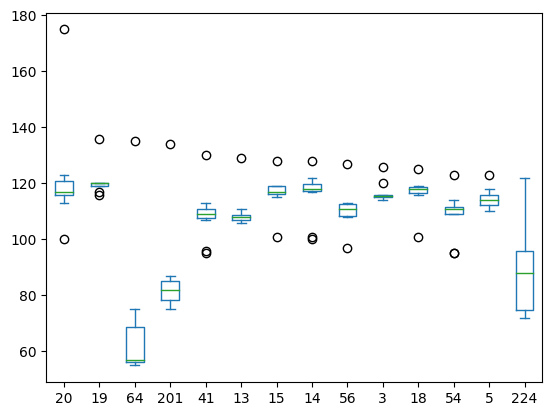

In [7]:
timings_per_query = pd.DataFrame({row["sample_id"] : row["timings"] for i, row in init_cache_seems_fine.iterrows()})
worst_timings = timings_per_query.iloc[:, 1:15]
worst_timings.plot.box()

##  Time/space trade-off

In [8]:
merlin_responses = pd.read_json(merlin_responses_json, lines = True)
all = pd.merge(init_cache_seems_fine, merlin_responses, on = "sample_id")
cpu_time = pd.DataFrame.from_records([{"time": row["responses"]["timing"]["clock"], "cpu" : row["merlin_reply"]["timing"]["cpu"]} for i, row in all[all["file"] == "lib/async_unix/src/tcp.ml"].iterrows()])
# cpu_time.plot.scatter(x="time", y="cpu")
cpu_time


TypeError: list indices must be integers or slices, not str